### Inference and Validation

In [33]:
import torch
from torchvision import datasets, transforms

# Deifne a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_date', download=True, train=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_date', download=True, train=True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [34]:
from torch import nn, optim
import torch.nn.functional as F

# Define network architecture
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0],-1) # Dont need to flatten the input tensor in trainng loop 
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1) 
        
        return x

In [35]:
model = Classifier()
images, labels = next(iter(testloader))

# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


In [36]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])
# Not trained yet so making guesses randomly and displaying top 10 classes

tensor([[5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5]])


In [39]:
# compare predicted with true class
equals = top_class == labels.view(*top_class.shape)
#print(equals)

In [40]:
# accuracy
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 10.9375%


The network is untrained so its's making random guesses and we should see an accuracy around 10%. Now let's train our netowrk and include our validation pass so we can measure how well the network is performing on the test set.
Since we are not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`


In [42]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss +=loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # trun off gradients for validation, saves memory and computations
        with torch.no_grad():
            # validation pass here
            for images, labels in testloader:
                log_ps = model(images)
                test_loss +=criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class =ps.topk(1, dim=1) # gives top classes or predicted classes
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        ## The validation pass and the validation accuracy
        print("Epoch: {}/{}..".format(e+1, epochs),
              "Training Loss: {:.3f}..".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}..".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}..".format(accuracy/len(testloader)),
             )
        

Epoch: 1/30.. Training Loss: 0.511.. Test Loss: 0.394.. Test Accuracy: 0.856..
Accuracy: 80306.25%
Epoch: 2/30.. Training Loss: 0.393.. Test Loss: 0.358.. Test Accuracy: 0.867..
Accuracy: 81346.875%
Epoch: 3/30.. Training Loss: 0.355.. Test Loss: 0.329.. Test Accuracy: 0.880..
Accuracy: 82578.125%
Epoch: 4/30.. Training Loss: 0.334.. Test Loss: 0.325.. Test Accuracy: 0.879..
Accuracy: 82431.25%
Epoch: 5/30.. Training Loss: 0.312.. Test Loss: 0.307.. Test Accuracy: 0.886..
Accuracy: 83100.0%
Epoch: 6/30.. Training Loss: 0.301.. Test Loss: 0.268.. Test Accuracy: 0.901..
Accuracy: 84468.75%
Epoch: 7/30.. Training Loss: 0.295.. Test Loss: 0.284.. Test Accuracy: 0.894..
Accuracy: 83878.125%
Epoch: 8/30.. Training Loss: 0.285.. Test Loss: 0.268.. Test Accuracy: 0.901..
Accuracy: 84509.375%
Epoch: 9/30.. Training Loss: 0.276.. Test Loss: 0.250.. Test Accuracy: 0.909..
Accuracy: 85250.0%
Epoch: 10/30.. Training Loss: 0.266.. Test Loss: 0.261.. Test Accuracy: 0.903..
Accuracy: 84682.8125%
Epoch

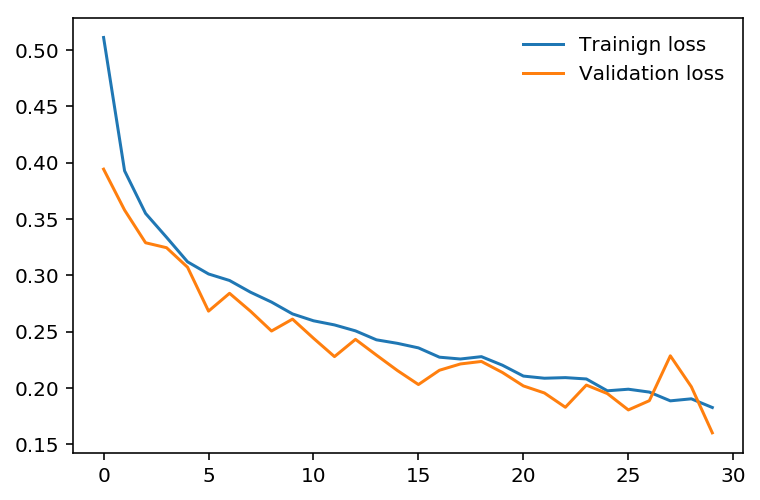

In [48]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label = 'Trainign loss')

plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()